In [1]:
# CUDA: Let's check that Nvidia CUDA drivers are already pre-installed and which version is it.
!/usr/local/cuda/bin/nvcc --version
# We need to install the correct cuDNN according to this output

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [2]:
!ls /usr/bin | grep nvidia
!echo $PATH

nvidia-bug-report.sh
nvidia-cuda-mps-control
nvidia-cuda-mps-server
nvidia-debugdump
nvidia-installer
nvidia-modprobe
nvidia-ngx-updater
nvidia-persistenced
nvidia-powerd
nvidia-settings
nvidia-sleep.sh
nvidia-smi
nvidia-uninstall
nvidia-xconfig
/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin


In [3]:
!nvidia-smi

Wed Dec 11 01:23:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              47W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

Add the dataset

In [4]:
pip install --upgrade dataset-tools

In [5]:
import dataset_tools as dtools

dtools.download(dataset='deepNIR Fruit Detection', dst_dir='~/dataset-ninja/')

Unpacking 'deepnir-fruit-detection.tar': 100%|██████████| 8593/8593 [00:04<00:00, 1772.91file/s]


'/root/dataset-ninja/deepnir-fruit-detection'

Check the structure of this dataset

In [6]:
!ls /root/dataset-ninja/deepnir-fruit-detection

LICENSE.md  meta.json  README.md  test	train  valid


In [11]:
# explore the categories under train
import os

dataset_path = "/root/dataset-ninja/deepnir-fruit-detection/train"

# List the contents of the training directory
categories = os.listdir(dataset_path)
print("Categories in train:", categories)

Categories in train: ['img', 'ann']


In [12]:
# Get the items under both cetegories
img_dir = os.path.join(dataset_path, "img")
ann_dir = os.path.join(dataset_path, "ann")

# List the contents of the img and ann directories
img_files = os.listdir(img_dir)
ann_files = os.listdir(ann_dir)

print("Number of images:", len(img_files))
print("Number of annotations:", len(ann_files))

Number of images: 3434
Number of annotations: 3434


In [13]:
# Get the number of items under testing class
test_path = "/root/dataset-ninja/deepnir-fruit-detection/test"
test_img_dir = os.path.join(test_path, "img")
test_ann_dir = os.path.join(test_path, "ann")

test_img_files = os.listdir(test_img_dir)
test_ann_files = os.listdir(test_ann_dir)

print("Number of testing images:", len(test_img_files))
print("Number of testing annotations:", len(test_ann_files))

Number of images: 431
Number of annotations: 431


In [14]:
# Get the number of items under validation class
valid_path = "/root/dataset-ninja/deepnir-fruit-detection/valid"
valid_img_dir = os.path.join(valid_path, "img")
valid_ann_dir = os.path.join(valid_path, "ann")

valid_img_files = os.listdir(valid_img_dir)
valid_ann_files = os.listdir(valid_ann_dir)

print("Number of validation images:", len(valid_img_files))
print("Number of validation annotations:", len(valid_ann_files))

Number of images: 430
Number of annotations: 430


In [22]:
# discover the "img" and "ann"
# Print the first five files in each directory
print("First five files in 'img':", img_files[:5])
print("First five files in 'ann':", ann_files[:5])

First five files in 'img': ['43f9b9fc5_jpg.rf.a6b1f02d76317de4ff04fc4f704c70b3.jpg', '7a9d28a53_jpg.rf.66f9a419123b1d56de073f04046d7fda.jpg', '178d835fd_jpg.rf.5805e26740dce88f393cebea31b00030.jpg', 'n12761284_11467_png.rf.35e87b9ef0f9d4e43c5d76375a6c22db.jpg', '56cb8b67d_jpg.rf.5a9a8629bb58a0ad892eb638a277d06b.jpg']
First five files in 'ann': ['56d818688_jpg.rf.d80bfa35c0edbd4742d31f93f8147e6f.jpg.json', '16e075fbb_jpg.rf.3643e6b7833e326c88a91a2007cf5700.jpg.json', '29a85cd12_jpg.rf.55c47ffb4ea6a3ea03b236eeee9e6fad.jpg.json', '20151125T1143_pic000304_png.rf.ed252b9e30a39dda375861d8276bf8f6.jpg.json', 'a7e2015b3_jpg.rf.8bac5f1f49fa31dbdc8bde9e4dd4bdad.jpg.json']


We can find that it's not sorted, so we need to pair them up artificially: ann name(.jpg) = file name.jpg(.json)

In [31]:
# dive into the format of annotation
sample_annotation = ann_files[0]
# Path to the annotation file
ann_path = os.path.join(ann_dir, sample_annotation)

# Load the JSON annotation
with open(ann_path, 'r') as f:
    annotation = json.load(f)

# Recursive function to remove empty fields
def clean_empty(data):
  # clean dicts
    if isinstance(data, dict):
        return {k: clean_empty(v) for k, v in data.items() if v not in [None, {}, [], ""]}
  # clean lists
    elif isinstance(data, list):
        return [clean_empty(v) for v in data if v not in [None, {}, [], ""]]
    else:
        return data

# Clean up empty fields from the annotation
cleaned_annotation = clean_empty(annotation)

# Print the cleaned JSON
print("Annotation in JSON format:")
print(json.dumps(cleaned_annotation, indent=4))

Annotation in JSON format:
{
    "size": {
        "height": 1024,
        "width": 1024
    },
    "objects": [
        {
            "id": 6229700,
            "classId": 8685,
            "geometryType": "rectangle",
            "labelerLogin": "iw@datasetninja.com",
            "createdAt": "2023-06-13T15:43:45.759Z",
            "updatedAt": "2023-06-13T15:43:45.759Z",
            "classTitle": "wheat",
            "points": {
                "exterior": [
                    [
                        221,
                        38
                    ],
                    [
                        291,
                        138
                    ]
                ]
            }
        },
        {
            "id": 6229699,
            "classId": 8685,
            "geometryType": "rectangle",
            "labelerLogin": "iw@datasetninja.com",
            "createdAt": "2023-06-13T15:43:45.759Z",
            "updatedAt": "2023-06-13T15:43:45.759Z",
            "classTitle":

Try to get the images with bounding boxes.

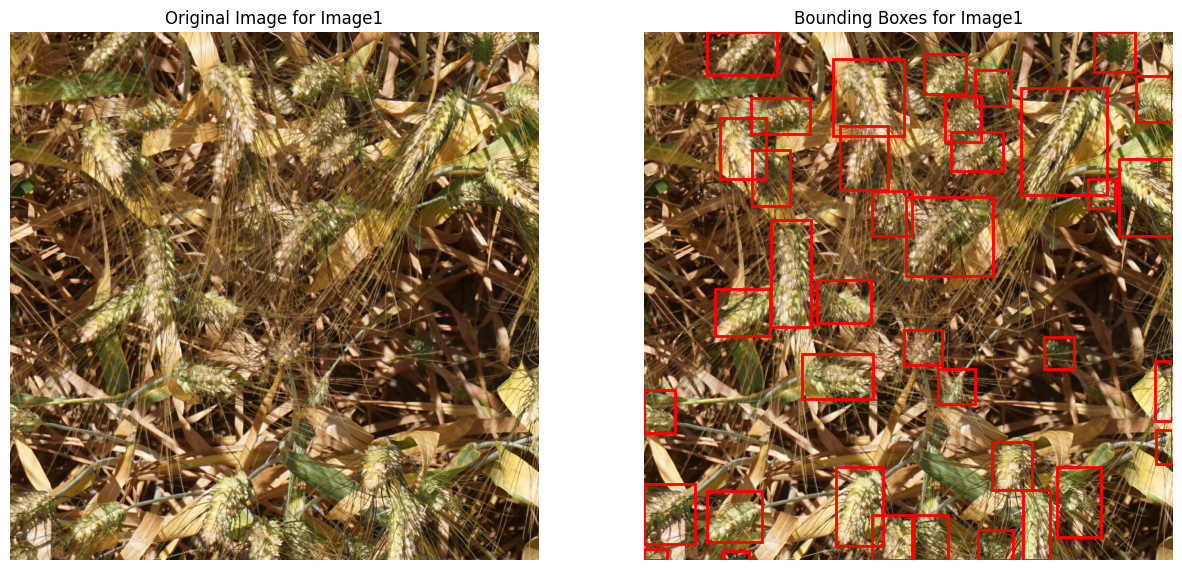

Object Class is: wheat
Num detected: 38
Bounding Boxes:
Box 1: (137, 498, 244, 590)
Box 2: (0, 695, 60, 777)
Box 3: (305, 624, 444, 712)
Box 4: (334, 480, 439, 565)
Box 5: (246, 364, 323, 572)
Box 6: (147, 167, 236, 285)
Box 7: (207, 129, 321, 198)
Box 8: (365, 53, 504, 202)
Box 9: (379, 183, 472, 307)
Box 10: (121, 0, 258, 84)
Box 11: (541, 43, 624, 120)
Box 12: (640, 74, 709, 143)
Box 13: (582, 125, 653, 214)
Box 14: (594, 195, 695, 269)
Box 15: (508, 321, 675, 473)
Box 16: (441, 309, 519, 395)
Box 17: (730, 109, 897, 316)
Box 18: (504, 577, 577, 646)
Box 19: (569, 653, 640, 722)
Box 20: (372, 844, 462, 996)
Box 21: (442, 937, 519, 1023)
Box 22: (523, 937, 588, 1023)
Box 23: (673, 795, 752, 888)
Box 24: (734, 888, 787, 1023)
Box 25: (647, 965, 714, 1023)
Box 26: (799, 844, 884, 978)
Box 27: (121, 889, 228, 988)
Box 28: (0, 877, 98, 992)
Box 29: (0, 1002, 43, 1023)
Box 30: (992, 772, 1023, 838)
Box 31: (990, 637, 1023, 754)
Box 32: (919, 246, 1023, 395)
Box 33: (860, 285, 913, 342)
Bo

In [34]:
import json
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Match the first image and its corresponding annotation
image_number = 0
first_image_file = img_files[image_number]
first_annotation_file = first_image_file + ".json"  # Append .json to match annotation file

# Paths to the image and annotation files
first_img_path = os.path.join(img_dir, first_image_file)
first_ann_path = os.path.join(ann_dir, first_annotation_file)

# Open the image
first_img = Image.open(first_img_path).convert("RGB")

# Load the JSON annotation
with open(first_ann_path, 'r') as f:
    annotation = json.load(f)

# Extract bounding box information from the JSON
bounding_boxes = []
for obj in annotation["objects"]:
    if obj["geometryType"] == "rectangle" and "points" in obj:
        # Extract the exterior points as the bounding box
        x_min, y_min = obj["points"]["exterior"][0]
        x_max, y_max = obj["points"]["exterior"][1]
        bounding_boxes.append((x_min, y_min, x_max, y_max))

# Plot the original and annotated images side-by-side
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
# the original image
axes[0].imshow(first_img)
axes[0].set_title(f"Original Image for Image{image_number + 1}")
axes[0].axis('off')
# the image with bounding boxes
axes[1].imshow(first_img)

# Add bounding boxes to the plot
for bbox in bounding_boxes:
    x_min, y_min, x_max, y_max = bbox
    width = x_max - x_min
    height = y_max - y_min
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='red', facecolor='none')
    axes[1].add_patch(rect)

# Set title and remove axes for better display
axes[1].set_title(f"Bounding Boxes for Image{image_number + 1}")
axes[1].axis('off')

# Display the image
plt.show()

# Extract detected object
detected_objects = [obj["classTitle"] for obj in annotation.get("objects", [])]
print(f"Object Class is: {detected_objects[0]}")

# Count the number of detected objects
num_objects = len(detected_objects)
print(f"Num detected: {num_objects}")

# Print details for the bounding boxes
print("Bounding Boxes:")
for idx, bbox in enumerate(bounding_boxes, 1):
    print(f"Box {idx}: {bbox}")

Now, we have the object class, num of objects and the details of bounding boxes.

Keep those with class_type = wheat

In [37]:
# check the class_type of each image
for img_file, ann_file in zip(img_files, ann_files):
    img_path = os.path.join(img_dir, img_file)
    ann_path = os.path.join(ann_dir, ann_file)

    # Load the annotation
    with open(ann_path, 'r') as f:
        annotation = json.load(f)

    # Check the class type
    if annotation.get("objects") and annotation["objects"][0]["classTitle"] != "wheat":
        # Delete the image and annotation files
        os.remove(img_path)
        os.remove(ann_path)

FileNotFoundError: [Errno 2] No such file or directory: '/root/dataset-ninja/deepnir-fruit-detection/train/ann/20151125T1143_pic000304_png.rf.ed252b9e30a39dda375861d8276bf8f6.jpg.json'

In [38]:
# List image and annotation files
img_files = sorted(os.listdir(img_dir))
ann_files = sorted(os.listdir(ann_dir))

print("Number of images after cleaning:", len(img_files))
print("Number of annotations after cleaning:", len(ann_files))

Number of images after cleaning: 2700
Number of annotations after cleaning: 2700
